In [95]:
import torch
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import os



DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TRAIN_DIR = "/kaggle/input/labtinkoff/CCPD2019-dl1/train/"
TEST_DIR = "/kaggle/input/labtinkoff/CCPD2019-dl1/test/"

In [96]:
idx2word = {0:'<blank>'}
word2idx= {'<blank>': 0}
b_idx = 1
class OCRdataset(torch.utils.data.Dataset):
    def __init__(self, datadir):
        global word2idx, idx2word, b_idx
        self.data = []
        self.labels = []
        self.dict = {}
        for filename in tqdm(os.listdir(datadir)):
            for s in filename[-11:-4]:
                if s not in word2idx.keys():
                    word2idx[s] = b_idx
                    idx2word[b_idx] = s
                    b_idx += 1
            self.labels.append(filename[-11:-4])
            self.data.append(datadir + filename)
            self.dict[filename[-11:-4]] = filename
        self.transform = transforms.Compose([
                        transforms.Grayscale(1),
                        transforms.Resize((32, 64)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img = self.transform(Image.open(self.data[index]))
        return img, torch.tensor([word2idx[s] for s in self.labels[index]])

In [97]:
train = OCRdataset(TRAIN_DIR)

100%|██████████| 199980/199980 [00:00<00:00, 401950.63it/s]


In [98]:
def collate_func(batch):
    data = torch.stack([i[0] for i in batch])
    targets = torch.stack([i[1] for i in batch])
    lengths = torch.tensor([len(i[1]) for i in batch])
    return data, targets, lengths

In [99]:
test = OCRdataset(TEST_DIR)

100%|██████████| 9999/9999 [00:00<00:00, 396584.83it/s]


In [100]:
train_loader = torch.utils.data.DataLoader(train,
                batch_size=64,
                collate_fn=collate_func,
                shuffle=True)

test_loader = torch.utils.data.DataLoader(test,
                batch_size=64,
                collate_fn=collate_func,
                shuffle=True)

# Creating Model
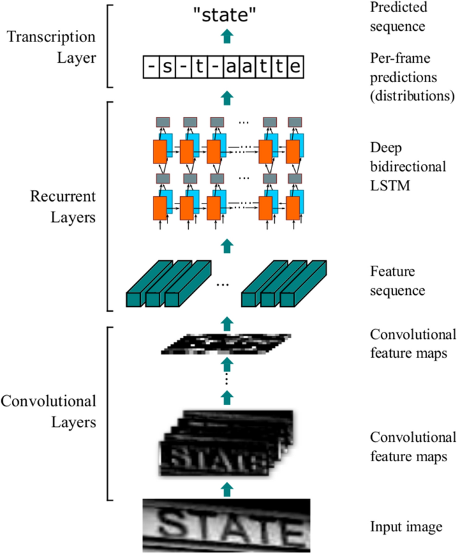

In [101]:
class BiLSTM(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.rnn = torch.nn.LSTM(n_in, n_hidden, bidirectional=True)
        self.embedding = torch.nn.Linear(n_hidden * 2, n_out)
    def forward(self, x):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(x)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)
        output = output.view(T, b, -1)
        return output

In [102]:
class OCRmodel(torch.nn.Module):
    def __init__(self, n_hidden, n_classes, n_channels, leakyRelu=False):
        super().__init__()
        
        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = torch.nn.Sequential()
        # there's a lot of conv layers and everyone of it needs in batchnorming and relu
        def conv_ReLU(i, batch_norm=False):
            in_n = n_channels if i == 0 else nm[i - 1]
            out = nm[i]
            cnn.add_module(f'conv{i}', torch.nn.Conv2d(in_n, out, ks[i], ss[i], ps[i]))
            if batch_norm:
                cnn.add_module(f'batchnorm{i}', torch.nn.BatchNorm2d(out))
            if leakyRelu:
                cnn.add_module(f'relu{i}', torch.nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module(f'relu{i}', torch.nn.ReLU(True))

        conv_ReLU(0)
        cnn.add_module('pooling0', torch.nn.MaxPool2d(2, 2))  # 64x16x64
        conv_ReLU(1)
        cnn.add_module('pooling1', torch.nn.MaxPool2d(2, 2))  # 128x8x32
        conv_ReLU(2, True)
        conv_ReLU(3)
        cnn.add_module('pooling2', torch.nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        conv_ReLU(4, True)
        conv_ReLU(5)
        cnn.add_module('pooling3', torch.nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        conv_ReLU(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = torch.nn.Sequential(
            BiLSTM(n_hidden*2, n_hidden, n_hidden),
            BiLSTM(n_hidden, n_hidden, n_classes))


    def forward(self, x):
        # conv features
        conv = self.cnn(x)
        b, c, h, w = conv.size()
        
        assert h == 1, f"the height of conv must be 1 but b={b} c={c} h={h} w={w}"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) # tbh -> bth
        return output


# Training

In [103]:
model = OCRmodel(n_hidden=256,n_classes=len(word2idx), n_channels=1).to(DEVICE)
criterion = torch.nn.CTCLoss(zero_infinity=True)
optimizer = torch.optim.Adagrad(model.parameters())

In [104]:
print(word2idx)

{'<blank>': 0, '皖': 1, 'A': 2, 'S': 3, 'H': 4, '8': 5, '0': 6, '7': 7, '1': 8, '6': 9, 'L': 10, '5': 11, 'Q': 12, 'V': 13, '2': 14, 'K': 15, '9': 16, 'C': 17, 'Y': 18, 'P': 19, 'Z': 20, '4': 21, 'D': 22, 'R': 23, 'X': 24, 'W': 25, 'B': 26, '3': 27, 'M': 28, 'T': 29, 'E': 30, 'J': 31, 'F': 32, 'G': 33, 'N': 34, '苏': 35, 'U': 36, '豫': 37, '闽': 38, '鲁': 39, '沪': 40, '京': 41, '浙': 42, '粤': 43, '渝': 44, '赣': 45, '蒙': 46, '湘': 47, '晋': 48, '鄂': 49, '川': 50, '津': 51, '陕': 52, '冀': 53, '云': 54, '辽': 55, '吉': 56, '青': 57, '桂': 58, '黑': 59, '贵': 60, '甘': 61, '新': 62, '琼': 63, '藏': 64, '宁': 65, 'O': 66}


In [105]:
example = next(iter(train_loader))
len(example[0])

64

In [106]:
for epoch in range(100):
    for batch, targets, lengths in train_loader:
        batch = batch.to(DEVICE)           
        logits = model(batch).transpose(1, 0)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, C = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        loss = criterion(logits, targets, pred_sizes, lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        avg_val = 0
        c = 0
        for batch, targets, lengths in test_loader:
            c += 1
            batch = batch.to(DEVICE)
            logits = model(batch).transpose(1, 0)
            logits = logits.contiguous().cpu()
            logits = torch.nn.functional.log_softmax(logits, 2)
            T, B, C = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            val_loss = criterion(logits, targets, pred_sizes, lengths)
            avg_val += val_loss
    print(f'Train loss:{loss} Val loss: {avg_val/c}')
    model.train() 

Train loss:0.007796742022037506 Val loss: 0.08519761264324188
Train loss:0.012179438024759293 Val loss: 0.05375067517161369
Train loss:0.001810967456549406 Val loss: 0.050125766545534134


KeyboardInterrupt: 

# Metric Calculating

In [107]:
print(loss)

tensor(0.0112, grad_fn=<MeanBackward0>)


In [108]:
def text_from_pred(pred):
    pred = ''.join(idx2word[s] for s in pred)
    ans = ''
    for i in range(len(pred)):
        if not ans or ans[-1] != pred[i]:
            ans += pred[i]
    return ans.replace('<blank>', '')

In [109]:
from torchmetrics import CharErrorRate
CER = CharErrorRate()
model.eval()
with torch.inference_mode():
    accuracy = 0
    max_loss = 0
    avg_loss = 0
    items = 0
    max_CER = 0
    avg_CER = 0
    
    for batch, targets, lengths in test_loader:
        for item, target in zip(batch, targets):
            batchy = item.unsqueeze(0).to(DEVICE)
            logits = model(batchy).transpose(1, 0)
            logits = logits.contiguous().cpu()
            logits = torch.nn.functional.log_softmax(logits, 2)
            T, B, C = logits.size()            
            items+=1
            
            test_loss = criterion(logits, target,[17], [7])
            avg_loss += test_loss

                
            logits = [s.item() for s in torch.argmax(logits, dim=2)]
            logits = text_from_pred(logits)
            logit_target = ''.join(idx2word[s.item()] for s in target)
            
            CERi = CER(logits, logit_target)
            avg_CER += CERi
            if CERi.item() == 0:
                accuracy += 1
            if CERi > max_CER:
                max_CER = CERi
                maxCERexample = logits
                maxCERtarget = logit_target
            
            if test_loss > max_loss:
                max_loss = test_loss
                ml_targets = logit_target
                mlExample = logits
                
    print(f'Max Loss={max_loss} Avg Loss={avg_loss/items}')
    print(f'Needed {ml_targets} gotten {mlExample}')
    print(f'Acc={accuracy/items}')
    print(f'Max CER={maxCER} Avg CER={avg_CER/items}')
    print(f'Needed {maxCERtarget} gotten {maxCERexample}')

Max Loss=6.637680530548096 Avg Loss=0.04727112501859665
Needed 皖AF888S gotten 皖E5PP9
Acc=0.9485948594859486
Max CER=1.1428571939468384 Avg CER=0.00981530174612999
Needed 皖AF888S gotten 皖E5PP9


0476-皖AF888S.jpg


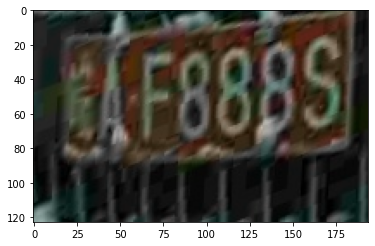

In [114]:
import cv2
print(test.dict[maxCERtarget])
plt.imshow(cv2.imread(TEST_DIR + test.dict[maxCERtarget]))
plt.imshow(cv2.imread(TEST_DIR + test.dict[ml_targets]))

It seems that the model did not recognize A and recognized F as E due to some image distortion. Further errors probably followed because of these two. Perhaps with more epochs the result would be a little better.